if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))# Pangyo AI Challenge 2021 - Mask Classification Baseline

# Change Epoch Back to 20!

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import gc

import matplotlib.pyplot as plt
import json
import pandas as pd
import time
from adamp import AdamP

In [2]:
os.getpid()

1852303

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [6]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [7]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_DIR = os.path.join(ROOT_PATH, 'test')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-7
INPUT_SHAPE = (180, 90)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
train_dataset = CustomDataset(db=train_db, mode='train', transform=transform)
validation_dataset = CustomDataset(db=valid_db, mode='val', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [10]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [11]:
import timm

In [12]:
# timm.list_models(pretrained=True)

In [13]:
EFF_BACKBONES = [
    'tf_efficientnetv2_l_in21ft1k',
    'tf_efficientnetv2_m_in21ft1k',
    'tf_efficientnetv2_s_in21ft1k'
]
NFN_BACKBONES = [
    'dm_nfnet_f0',
    'dm_nfnet_f1',
    'eca_nfnet_l2',
    'eca_nfnet_l1',
]
    
DEIT_BACKBONES = [
    'deit_base_distilled_patch16_224',
    'deit_base_distilled_patch16_384'   
]  

In [14]:
# # lighter models to experiment on

# EFF_BACKBONES = [
#     'tf_efficientnet_b5_ns',
#     'tf_efficientnet_b6_ns',
#     'tf_efficientnet_b7_ns',
#     'efficientnetv2_rw_s',
#     'efficientnetv2_rw_m',
#     'tf_efficientnetv2_s_in21k',
#     'tf_efficientnetv2_s_in21ft1k',
#     'tf_efficientnetv2_m_in21k',
#     'tf_efficientnetv2_m_in21ft1k'
# ]
# NFN_BACKBONES = [
#     'eca_nfnet_l0',
#     'eca_nfnet_l1',
#     'eca_nfnet_l2'
# ]

In [15]:
class DebuggerNet(nn.Module):
    def __init__(self):
        super(DebuggerNet, self).__init__()
        self.conv = nn.Conv2d(3, 3, 3, 3)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.linear = nn.Linear(12, 2)

    def forward(self, input_img):
        x = self.avgpool(input_img)

        x = x.view(-1, 12)
        x = self.linear(x)
        return x


In [16]:
from torch.nn import functional as F
# for efficientnet
class EFFMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(EFFMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x


In [17]:
# for nfnet
class NFNMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(NFNMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

In [18]:
# for deit
class DEITMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(DEITMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        in_features_head = self.model.head.in_features
        in_features_head_dist = self.model.head_dist.in_features
        
        self.model.head = nn.Linear(in_features_head, 2)
        self.model.head_dist = nn.Linear(in_features_head_dist, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## Just Trainer

In [19]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            pred = F.softmax(pred)

            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            pred = F.softmax(pred)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)


## SAM Optimizer w. AdamP

In [20]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

## MultiScale Trainer

In [21]:
class MultiScale_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, scales, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.scales = scales
        self.scales_max_index = len(self.scales) - 1
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = TF.resize(img, self.scales[np.random.randint(0, self.scales_max_index)])
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


# SAM Trainer

In [22]:
class SAM_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
        
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            loss.backward()
            self.optimizer.first_step(zero_grad=True)
            self.criterion(self.model(img), label).backward()
            self.optimizer.second_step(zero_grad=True)
            
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [24]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

#### Test set Loader

In [25]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [26]:
class CheckDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [27]:
def check_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [28]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = check_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [29]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [30]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [31]:
check_dataset = CheckDataset(db=test_db, mode='check', transform=transform)
check_dataloader = DataLoader(check_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


# Misc.

In [33]:
def plot_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

In [34]:
def wait_and_flush():
    
    print("waiting...")
    
    time.sleep(120)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("flushing...")
    time.sleep(60)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("done!")

In [35]:
def pretty_size(size):

    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

# dump_tensors()

# 학습 Function

In [36]:
def EFF_train_val_infer(BACKBONE):
    model = EFFMaskClassifier(BACKBONE).to(device)
    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-7)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_acc_history, valid_acc_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v2.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}

    
    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v2_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

In [37]:
def NFN_train_val_infer(BACKBONE):
    model = NFNMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())


    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v2.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v2_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)

    wait_and_flush()

In [38]:
def DEIT_train_val_infer(BACKBONE):
    model = DEITMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v2.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v2_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

# Debugging Purposes

In [39]:
def DEBUG_train_val_infer(BACKBONE="debug"):
    model = DebuggerNet().to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

In [40]:
# DEBUG_train_val_infer()

# 기차 = Train

In [41]:
save_csv = pd.DataFrame()

# Efficient Family

In [42]:
print(len(EFF_BACKBONES))
print(EFF_BACKBONES)

3
['tf_efficientnetv2_l_in21ft1k', 'tf_efficientnetv2_m_in21ft1k', 'tf_efficientnetv2_s_in21ft1k']


    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_l_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.40685331036295164, Acc: 0.8175332130556011, ROC: 0.8876347784423188
Epoch 0, Val loss: 0.29870876594937057, Acc: 0.8892988929889298, ROC: 0.9598491759682435


  5%|▌         | 1/20 [14:16<4:31:20, 856.85s/it]

Epoch 1, Train loss: 0.24269291861202774, Acc: 0.9072494669509595, ROC: 0.9696490673715863
Epoch 1, Val loss: 0.2081449283342037, Acc: 0.9261992619926199, ROC: 0.9842421655263655


 10%|█         | 2/20 [28:28<4:16:06, 853.71s/it]

Epoch 2, Train loss: 0.1544074883068523, Acc: 0.9479252091192389, ROC: 0.9888818441324659
Epoch 2, Val loss: 0.13704383061901176, Acc: 0.9490774907749078, ROC: 0.9922726647046465


 15%|█▌        | 3/20 [43:23<4:07:16, 872.72s/it]

Epoch 3, Train loss: 0.0950191183525365, Acc: 0.9708463178612432, ROC: 0.9963964887444122
Epoch 3, Val loss: 0.10715517147923627, Acc: 0.9642066420664207, ROC: 0.9948857813352474


 20%|██        | 4/20 [1:04:27<4:33:56, 1027.31s/it]

Epoch 4, Train loss: 0.05613031511847663, Acc: 0.9863867475807774, ROC: 0.9989543986100428
Epoch 4, Val loss: 0.09567833741294694, Acc: 0.9715867158671587, ROC: 0.9961435770774667


 25%|██▌       | 5/20 [1:25:35<4:38:26, 1113.79s/it]

Epoch 5, Train loss: 0.030857030810801107, Acc: 0.9939724454649828, ROC: 0.9997526445565166
Epoch 5, Val loss: 0.0707247957157401, Acc: 0.977859778597786, ROC: 0.9970034702233437


 30%|███       | 6/20 [1:46:44<4:32:11, 1166.52s/it]

Epoch 6, Train loss: 0.016097837710222797, Acc: 0.997867803837953, ROC: 0.9999458707851493
Epoch 6, Val loss: 0.06898441855635869, Acc: 0.977490774907749, ROC: 0.9968006179193261


 35%|███▌      | 7/20 [2:07:52<4:19:59, 1199.96s/it]

Epoch 7, Train loss: 0.008532985853971003, Acc: 0.9989749056913236, ROC: 0.9999888053600404
Epoch 7, Val loss: 0.06622572186349246, Acc: 0.9793357933579335, ROC: 0.9971316461297284


 40%|████      | 8/20 [2:29:02<4:04:27, 1222.27s/it]

Epoch 8, Train loss: 0.005252807103770799, Acc: 0.9994669509594882, ROC: 0.9999967730263424
Epoch 8, Val loss: 0.05981994261015406, Acc: 0.9804428044280443, ROC: 0.9974587733342845


 45%|████▌     | 9/20 [2:50:16<3:47:00, 1238.25s/it]

Epoch 9, Train loss: 0.0027556965435254336, Acc: 0.9997949811382647, ROC: 0.999999181215639


 50%|█████     | 10/20 [3:11:22<3:27:47, 1246.78s/it]

Epoch 9, Val loss: 0.06467767311318656, Acc: 0.9830258302583026, ROC: 0.9973969145272901
Epoch 10, Train loss: 0.0015961150691801058, Acc: 0.9998359849106118, ROC: 0.9999996559729577


 55%|█████▌    | 11/20 [3:32:31<3:08:02, 1253.63s/it]

Epoch 10, Val loss: 0.06396199042987892, Acc: 0.9837638376383764, ROC: 0.9976995211236679
Epoch 11, Train loss: 0.0007252649596667172, Acc: 0.9999179924553059, ROC: 1.0


 60%|██████    | 12/20 [3:53:35<2:47:35, 1256.98s/it]

Epoch 11, Val loss: 0.06673868174896774, Acc: 0.9845018450184502, ROC: 0.9975317778722688
Epoch 12, Train loss: 0.0004240131756587539, Acc: 1.0, ROC: 1.0


 65%|██████▌   | 13/20 [4:14:39<2:26:52, 1258.92s/it]

Epoch 12, Val loss: 0.06373713135530899, Acc: 0.9822878228782288, ROC: 0.9975027989716949
Epoch 13, Train loss: 0.00018617839616659059, Acc: 1.0, ROC: 1.0


 70%|███████   | 14/20 [4:33:10<2:01:26, 1214.41s/it]

Epoch 13, Val loss: 0.07830619037201074, Acc: 0.9833948339483395, ROC: 0.9970764747613281
Epoch 14, Train loss: 0.00013833877421725173, Acc: 1.0, ROC: 1.0


 75%|███████▌  | 15/20 [4:59:11<1:49:54, 1318.82s/it]

Epoch 14, Val loss: 0.07223187796903699, Acc: 0.9830258302583026, ROC: 0.9973545607495282
Epoch 15, Train loss: 5.501272592315764e-05, Acc: 1.0, ROC: 1.0


 80%|████████  | 16/20 [5:27:32<1:35:34, 1433.71s/it]

Epoch 15, Val loss: 0.08104937232633751, Acc: 0.9841328413284133, ROC: 0.9975629859190407
Epoch 16, Train loss: 3.800414853068431e-05, Acc: 1.0, ROC: 0.9999999999999999


 85%|████████▌ | 17/20 [5:55:53<1:15:42, 1514.04s/it]

Epoch 16, Val loss: 0.07441077711053518, Acc: 0.9811808118081181, ROC: 0.9976371050301243
Epoch 17, Train loss: 7.18691759959517e-05, Acc: 1.0, ROC: 1.0


 90%|█████████ | 18/20 [6:18:12<48:43, 1461.69s/it]  

Epoch 17, Val loss: 0.07846965248407249, Acc: 0.9830258302583026, ROC: 0.997776426667499
Epoch 18, Train loss: 2.530732516309935e-05, Acc: 1.0, ROC: 1.0


 95%|█████████▌| 19/20 [6:32:31<21:20, 1280.54s/it]

Epoch 18, Val loss: 0.07708585987754611, Acc: 0.9859778597785978, ROC: 0.9978839829715522
Epoch 19, Train loss: 3.3999712808530555e-05, Acc: 1.0, ROC: 1.0


100%|██████████| 20/20 [6:46:49<00:00, 1220.45s/it]

Epoch 19, Val loss: 0.08396830452838294, Acc: 0.9833948339483395, ROC: 0.9975156165623335


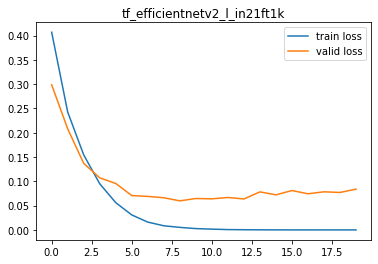

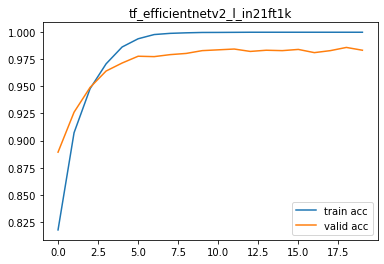

Epoch 0, Val loss: 0.5652804813871626, Acc: 0.8567251461988304, ROC: 0.9290575079872204
waiting...
flushing...
done!


In [44]:
#0
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#1
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except: 
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.46935383453378526, Acc: 0.7814908971625389, ROC: 0.839627744988331
Epoch 0, Val loss: 0.3642649688487928, Acc: 0.8656826568265683, ROC: 0.9381874477892166


  5%|▌         | 1/20 [10:07<3:12:26, 607.69s/it]

Epoch 1, Train loss: 0.30049736957185536, Acc: 0.8791618828932262, ROC: 0.9506270759795833
Epoch 1, Val loss: 0.24384482032977617, Acc: 0.9103321033210332, ROC: 0.9732335270275618


 10%|█         | 2/20 [20:36<3:06:05, 620.30s/it]

Epoch 2, Train loss: 0.21521662771359595, Acc: 0.919345579793341, ROC: 0.9765012535106928
Epoch 2, Val loss: 0.1902973128802325, Acc: 0.9357933579335793, ROC: 0.9844171535029081


 15%|█▌        | 3/20 [31:03<2:56:31, 623.04s/it]

Epoch 3, Train loss: 0.15610359698103796, Acc: 0.9469411185829096, ROC: 0.9885250708881483
Epoch 3, Val loss: 0.15918638947359204, Acc: 0.9509225092250922, ROC: 0.990887250342592


 20%|██        | 4/20 [41:24<2:45:56, 622.25s/it]

Epoch 4, Train loss: 0.11103559377556789, Acc: 0.9656388387731671, ROC: 0.9947377210762499
Epoch 4, Val loss: 0.11553398353879797, Acc: 0.9590405904059041, ROC: 0.9935176428562273


 25%|██▌       | 5/20 [51:40<2:35:00, 620.02s/it]

Epoch 5, Train loss: 0.07369176915044996, Acc: 0.9799081515499426, ROC: 0.9981470153053227
Epoch 5, Val loss: 0.09626994494034649, Acc: 0.9690036900369003, ROC: 0.9949788481890137


 30%|███       | 6/20 [1:01:51<2:23:59, 617.13s/it]

Epoch 6, Train loss: 0.04860305502351368, Acc: 0.9891340003280302, ROC: 0.9993181590435917
Epoch 6, Val loss: 0.0901996785135576, Acc: 0.9719557195571956, ROC: 0.9959418393465481


 35%|███▌      | 7/20 [1:12:12<2:13:59, 618.42s/it]

Epoch 7, Train loss: 0.030812027492148564, Acc: 0.9935624077415122, ROC: 0.9997879554921482
Epoch 7, Val loss: 0.07585570583266024, Acc: 0.9760147601476015, ROC: 0.9961758996973378


 40%|████      | 8/20 [1:22:26<2:03:23, 616.98s/it]

Epoch 8, Train loss: 0.019746123414862933, Acc: 0.9963916680334591, ROC: 0.999919139883955
Epoch 8, Val loss: 0.07303937470826966, Acc: 0.977859778597786, ROC: 0.9965074851942896


 45%|████▌     | 9/20 [1:32:47<1:53:18, 618.09s/it]

Epoch 9, Train loss: 0.01201119088890189, Acc: 0.9979088076103001, ROC: 0.9999861769934365
Epoch 9, Val loss: 0.0667143103941454, Acc: 0.9782287822878228, ROC: 0.9970346782701156


 50%|█████     | 10/20 [1:46:03<1:52:10, 673.02s/it]

Epoch 10, Train loss: 0.0075313641499253825, Acc: 0.9990159094636707, ROC: 0.999995252426815
Epoch 10, Val loss: 0.06128563336337801, Acc: 0.9785977859778597, ROC: 0.997432580866458


 55%|█████▌    | 11/20 [2:00:02<1:48:34, 723.85s/it]

In [ ]:
#2
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# NFNet Family

In [46]:
print(len(NFN_BACKBONES))
print(NFN_BACKBONES)

5
['dm_nfnet_f6', 'dm_nfnet_f4', 'dm_nfnet_f2', 'eca_nfnet_l2', 'eca_nfnet_l1']


In [41]:
INDEX = 1

In [43]:
NFN_train_val_infer(NFN_BACKBONES[INDEX])

  0%|          | 0/1 [00:00<?, ?it/s]


AssertionError: Sharpness Aware Minimization requires closure, but it was not provided

In [ ]:
#0
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    eca_nfnet_l1    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecanfnet_l1_ra2-7dce93cd.pth" to /home/ys/.cache/torch/hub/checkpoints/ecanfnet_l1_ra2-7dce93cd.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.17334841026228198, Acc: 0.9302525832376579, ROC: 0.9811702612400997
Epoch 0, Val loss: 0.3535317164906383, Acc: 0.9708487084870848, ROC: 0.9954441824578455


  5%|▌         | 1/20 [04:17<1:21:23, 257.02s/it]

Epoch 1, Train loss: 0.0477086268223206, Acc: 0.9844185665081188, ROC: 0.9981271030201089
Epoch 1, Val loss: 0.3471882087591837, Acc: 0.9712177121771217, ROC: 0.9952496894520703


 10%|█         | 2/20 [08:31<1:16:43, 255.74s/it]

Epoch 2, Train loss: 0.02454612790630644, Acc: 0.9919632606199771, ROC: 0.9994432954399932
Epoch 2, Val loss: 0.3428765775183954, Acc: 0.9715867158671587, ROC: 0.9953544593233761


 15%|█▌        | 3/20 [12:48<1:12:31, 255.99s/it]

Epoch 3, Train loss: 0.014872491752815907, Acc: 0.9954895850418238, ROC: 0.9996916141591953
Epoch 3, Val loss: 0.34047698286863476, Acc: 0.9756457564575646, ROC: 0.9966415126094442


 20%|██        | 4/20 [17:01<1:07:57, 254.86s/it]

Epoch 4, Train loss: 0.01433366664459021, Acc: 0.9952845661800885, ROC: 0.9998074790268041


 25%|██▌       | 5/20 [21:18<1:03:54, 255.62s/it]

Epoch 4, Val loss: 0.3464800935877851, Acc: 0.9682656826568266, ROC: 0.9945580968441419
Epoch 5, Train loss: 0.012278291609473297, Acc: 0.9959406265376415, ROC: 0.9998689188163059
Epoch 5, Val loss: 0.3393644068015398, Acc: 0.9745387453874539, ROC: 0.9960987155102321


 30%|███       | 6/20 [25:33<59:39, 255.64s/it]  

Epoch 6, Train loss: 0.009730461997471084, Acc: 0.9964736755781531, ROC: 0.9999384260399519
Epoch 6, Val loss: 0.33670399827364633, Acc: 0.9793357933579335, ROC: 0.9962943230891061


 35%|███▌      | 7/20 [29:49<55:24, 255.75s/it]

Epoch 7, Train loss: 0.008053151134099986, Acc: 0.997867803837953, ROC: 0.9998549409975732


 40%|████      | 8/20 [34:04<51:05, 255.43s/it]

Epoch 7, Val loss: 0.35963310627542305, Acc: 0.9546125461254612, ROC: 0.9939381155578243
Epoch 8, Train loss: 0.010726011187940181, Acc: 0.9965556831228473, ROC: 0.9998643260552899


 45%|████▌     | 9/20 [38:19<46:46, 255.15s/it]

Epoch 8, Val loss: 0.3469478678421156, Acc: 0.970110701107011, ROC: 0.9958652124459919
Epoch 9, Train loss: 0.006236474176412683, Acc: 0.9982778415614236, ROC: 0.9998818955163451


 50%|█████     | 10/20 [42:34<42:32, 255.28s/it]

Epoch 9, Val loss: 0.342125547884484, Acc: 0.9730627306273063, ROC: 0.9965894063170659
Epoch 10, Train loss: 0.007384686245780384, Acc: 0.997744792520912, ROC: 0.9999509692659175
Epoch 10, Val loss: 0.3346711504741533, Acc: 0.9804428044280443, ROC: 0.9963848821533998


 55%|█████▌    | 11/20 [46:45<38:04, 253.81s/it]

Epoch 11, Train loss: 0.006492943573064346, Acc: 0.9979088076103001, ROC: 0.9999661202168648


 60%|██████    | 12/20 [50:59<33:52, 254.07s/it]

Epoch 11, Val loss: 0.33528198822010197, Acc: 0.9782287822878228, ROC: 0.9964071736153798
Epoch 12, Train loss: 0.006307672705850819, Acc: 0.9982778415614236, ROC: 0.9999039889330078


 65%|██████▌   | 13/20 [55:14<29:40, 254.37s/it]

Epoch 12, Val loss: 0.3422679282151736, Acc: 0.9749077490774908, ROC: 0.9948679481656635
Epoch 13, Train loss: 0.01187085086673525, Acc: 0.9973757585697884, ROC: 0.9998669200191895


 70%|███████   | 14/20 [59:29<25:27, 254.50s/it]

Epoch 13, Val loss: 0.335421750355049, Acc: 0.9800738007380074, ROC: 0.996928515182436
Epoch 14, Train loss: 0.0032038111779500466, Acc: 0.9990569132360178, ROC: 0.9999869338529297


 75%|███████▌  | 15/20 [1:03:44<21:13, 254.64s/it]

Epoch 14, Val loss: 0.3447066358560641, Acc: 0.9704797047970479, ROC: 0.9951014512299035
Epoch 15, Train loss: 0.005842919817010662, Acc: 0.9982368377890766, ROC: 0.99994190071308
Epoch 15, Val loss: 0.3343655615163273, Acc: 0.9811808118081181, ROC: 0.9976970133341952


 80%|████████  | 16/20 [1:08:00<16:59, 254.98s/it]

Epoch 16, Train loss: 0.004199232135289574, Acc: 0.9986058717402001, ROC: 0.9999764410281367


 85%|████████▌ | 17/20 [1:12:16<12:46, 255.37s/it]

Epoch 16, Val loss: 0.341079388849834, Acc: 0.9734317343173432, ROC: 0.9961728346213155
Epoch 17, Train loss: 0.008811337722714247, Acc: 0.9975807774315237, ROC: 0.99984688044397


 90%|█████████ | 18/20 [1:16:30<08:29, 254.91s/it]

Epoch 17, Val loss: 0.34090346803326577, Acc: 0.9726937269372694, ROC: 0.9962059931710107
Epoch 18, Train loss: 0.003513228730821751, Acc: 0.9990159094636707, ROC: 0.9999711017284387


 95%|█████████▌| 19/20 [1:20:46<04:15, 255.32s/it]

Epoch 18, Val loss: 0.33530614749919735, Acc: 0.9793357933579335, ROC: 0.997025483042049
Epoch 19, Train loss: 0.004131437145625668, Acc: 0.9986878792848942, ROC: 0.9999866655118367


100%|██████████| 20/20 [1:25:00<00:00, 255.02s/it]

Epoch 19, Val loss: 0.34003217139187647, Acc: 0.9738007380073801, ROC: 0.9961572305979295


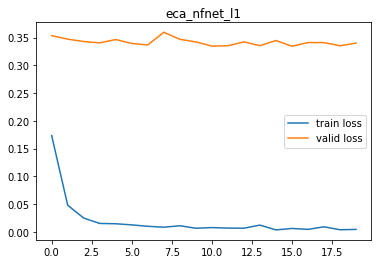

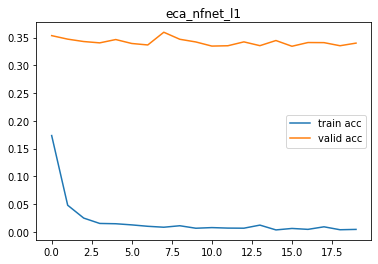

Epoch 0, Val loss: 0.44408326828852296, Acc: 0.8703703703703703, ROC: 0.9329412939297124
waiting...
flushing...
done!


In [40]:
#1
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [41]:
#2
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    eca_nfnet_l2    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [01:30<?, ?it/s]


In [ ]:
# #3
# try:
#     print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
#     NFN_train_val_infer(NFN_BACKBONES[INDEX])
# except:
#     pass
# INDEX += 1

In [35]:
INDEX = 4

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    dm_nfnet_f4    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.18918851932423345, Acc: 0.9232409381663113, ROC: 0.9776664318200464
Epoch 0, Val loss: 0.3579118928965732, Acc: 0.9697416974169741, ROC: 0.9940587680957909


  5%|▌         | 1/20 [11:14<3:33:38, 674.64s/it]

Epoch 1, Train loss: 0.06145246241525637, Acc: 0.9801131704116779, ROC: 0.9969240163709535


 10%|█         | 2/20 [22:26<3:21:49, 672.73s/it]

Epoch 1, Val loss: 0.36831799414030897, Acc: 0.9586715867158672, ROC: 0.9929698301780697
Epoch 2, Train loss: 0.043442088621674126, Acc: 0.986796785304248, ROC: 0.9982231140871011
Epoch 2, Val loss: 0.34846041064995986, Acc: 0.9690036900369003, ROC: 0.9939358864116262


 15%|█▌        | 3/20 [33:40<3:10:50, 673.57s/it]

Epoch 3, Train loss: 0.022807492757412184, Acc: 0.9928653436116123, ROC: 0.9994356167564068
Epoch 3, Val loss: 0.3411018328201136, Acc: 0.9738007380073801, ROC: 0.996514729919433


 20%|██        | 4/20 [44:55<2:59:47, 674.20s/it]

Epoch 4, Train loss: 0.02190355829372142, Acc: 0.9931933737903887, ROC: 0.9995056365803459


 25%|██▌       | 5/20 [56:08<2:48:26, 673.75s/it]

Epoch 4, Val loss: 0.34463748036051645, Acc: 0.9693726937269372, ROC: 0.9948941406334898
Epoch 5, Train loss: 0.01789481887120064, Acc: 0.9946695095948828, ROC: 0.999626080447889


 30%|███       | 6/20 [1:07:19<2:36:57, 672.70s/it]

Epoch 5, Val loss: 0.34691047298132316, Acc: 0.9678966789667897, ROC: 0.9954539349724617
Epoch 6, Train loss: 0.015429527306437875, Acc: 0.9951205510907003, ROC: 0.9996886176836561
Epoch 6, Val loss: 0.3377213229441784, Acc: 0.9771217712177122, ROC: 0.99686303401287


 35%|███▌      | 7/20 [1:18:33<2:25:52, 673.28s/it]

Epoch 7, Train loss: 0.018539361395602125, Acc: 0.9946285058225357, ROC: 0.9995942338645744


 40%|████      | 8/20 [1:29:47<2:14:40, 673.41s/it]

Epoch 7, Val loss: 0.34460541658852933, Acc: 0.9726937269372694, ROC: 0.9935817308094196
Epoch 8, Train loss: 0.01772280917513857, Acc: 0.994833524684271, ROC: 0.9995949012770368


 45%|████▌     | 9/20 [1:40:58<2:03:17, 672.53s/it]

Epoch 8, Val loss: 0.3455637432414399, Acc: 0.9697416974169741, ROC: 0.9947548189961151
Epoch 9, Train loss: 0.014282451226177889, Acc: 0.9959816303099885, ROC: 0.9997195353939562


 50%|█████     | 10/20 [1:52:06<1:51:53, 671.38s/it]

Epoch 9, Val loss: 0.3402522916977222, Acc: 0.9749077490774908, ROC: 0.996514729919433
Epoch 10, Train loss: 0.006467795184707083, Acc: 0.9982368377890766, ROC: 0.9998906200421402


 55%|█████▌    | 11/20 [2:03:17<1:40:39, 671.03s/it]

Epoch 10, Val loss: 0.341083435617255, Acc: 0.9738007380073801, ROC: 0.9962572635335646
Epoch 11, Train loss: 0.011130574641811108, Acc: 0.9968017057569296, ROC: 0.9998395389068853


 60%|██████    | 12/20 [2:14:29<1:29:30, 671.36s/it]

Epoch 11, Val loss: 0.33816807245361735, Acc: 0.977859778597786, ROC: 0.9961619675336002
Epoch 12, Train loss: 0.011017871714860163, Acc: 0.9967196982122355, ROC: 0.9998137403189759


 65%|██████▌   | 13/20 [2:25:41<1:18:20, 671.55s/it]

Epoch 12, Val loss: 0.3378445671860283, Acc: 0.9782287822878228, ROC: 0.9958367908319675
Epoch 13, Train loss: 0.01085916177511111, Acc: 0.9968017057569296, ROC: 0.9998259291970878


 70%|███████   | 14/20 [2:36:50<1:07:05, 670.93s/it]

Epoch 13, Val loss: 0.3382930073159686, Acc: 0.9760147601476015, ROC: 0.996256706247015
Epoch 14, Train loss: 0.008205863985362495, Acc: 0.9976217812038708, ROC: 0.9999062182282425


 75%|███████▌  | 15/20 [2:48:00<55:53, 670.62s/it]  

Epoch 14, Val loss: 0.3475543708490902, Acc: 0.9638376383763838, ROC: 0.9938247077450012
Epoch 15, Train loss: 0.008337509735550948, Acc: 0.997785796293259, ROC: 0.9998495053703033


 80%|████████  | 16/20 [2:59:10<44:41, 670.35s/it]

Epoch 15, Val loss: 0.34181471407060793, Acc: 0.9715867158671587, ROC: 0.9947459024113232
Epoch 16, Train loss: 0.009676896720091322, Acc: 0.9972117434804002, ROC: 0.999878940324051


 85%|████████▌ | 17/20 [3:10:24<33:34, 671.54s/it]

Epoch 16, Val loss: 0.34357632846521907, Acc: 0.9708487084870848, ROC: 0.9956762923057119
Epoch 17, Train loss: 0.008011860123111931, Acc: 0.997744792520912, ROC: 0.9999019729345394


 90%|█████████ | 18/20 [3:21:40<22:25, 672.85s/it]

Epoch 17, Val loss: 0.3419062916696424, Acc: 0.9719557195571956, ROC: 0.9947982873469761
Epoch 18, Train loss: 0.008093299638549198, Acc: 0.9978268000656061, ROC: 0.9999187270515042


 95%|█████████▌| 19/20 [3:32:51<11:12, 672.29s/it]

Epoch 18, Val loss: 0.34180718184222836, Acc: 0.9723247232472325, ROC: 0.9953104336859657
Epoch 19, Train loss: 0.009474841283242212, Acc: 0.997047728391012, ROC: 0.9998004299127053
Epoch 19, Val loss: 0.3374683412574452, Acc: 0.9763837638376384, ROC: 0.9959387742705259


100%|██████████| 20/20 [3:44:06<00:00, 672.32s/it]


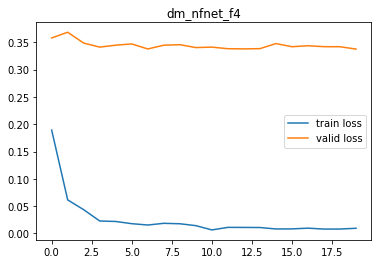

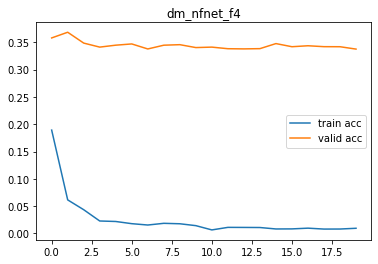

Epoch 0, Val loss: 0.44461027067154646, Acc: 0.8703703703703703, ROC: 0.9300459265175721
waiting...
flushing...
done!


In [36]:
#4
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [36]:
INDEX = 5

In [37]:
#5
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    dm_nfnet_f6    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


# DEIT Couple

In [ ]:
# need to resize image for using this

In [ ]:
DEIT_BACKBONES

In [ ]:
# DEIT_train_val_infer(DEIT_BACKBONES[1])